In [1]:
import torch
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/',
                                 download=True,
                                 train=True,
                                 transform=transform)
trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=64,
                                          shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/',
                                download=True,
                                train=False,
                                transform=transform)
testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=64,
                                         shuffle=True)


100%|██████████| 26421880/26421880 [00:02<00:00, 10506005.09it/s]


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 171229.59it/s]


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3158423.00it/s]


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 10705144.77it/s]

Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



In [2]:
# helper function to print one of the images.
import matplotlib.pyplot as plt
import numpy as np

def imshow(image, ax=None, title=None, normalize=True):
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax


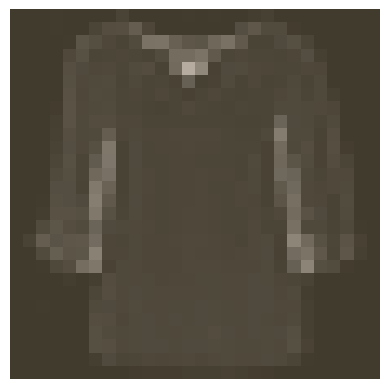

In [3]:
# print one image
image, label = next(iter(trainloader))
imshow(image[0,:]);

In [4]:
# Defining the Network Architecture
# As with MNIST, each image is 28x28 which is a total of 784 pixels, and there are 10 classes.

from torch import nn

model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.MaxPool1d(1),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.MaxPool1d(1),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1))

In [5]:
# Define the optimizer
from torch import optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [6]:
# Make a forward pass through the network to get the logits
# Use the logits to calculate the loss
# Perform a backward pass through the network with loss.backward() to calculate the gradients
# Take a step with the optimizer to update the weights
# stop when the loss drops below 0.4

epoch = 1
while True:
    running_loss = 0
    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)

        optimizer.zero_grad()

        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    training_loss = running_loss/len(trainloader)
    print("Epoch, Loss:    {:2}, {:1.3}".format(epoch, training_loss))
    epoch += 1

    if training_loss < 0.2:
        break


Epoch, Loss:     1, 0.521
Epoch, Loss:     2, 0.38
Epoch, Loss:     3, 0.343
Epoch, Loss:     4, 0.323
Epoch, Loss:     5, 0.301
Epoch, Loss:     6, 0.285
Epoch, Loss:     7, 0.274
Epoch, Loss:     8, 0.261
Epoch, Loss:     9, 0.253
Epoch, Loss:    10, 0.243
Epoch, Loss:    11, 0.231
Epoch, Loss:    12, 0.225
Epoch, Loss:    13, 0.218
Epoch, Loss:    14, 0.209
Epoch, Loss:    15, 0.203
Epoch, Loss:    16, 0.198


In [7]:
from torch.autograd import Variable
model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in testloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
        labels = Variable(labels)

        optimizer.zero_grad()

        output = model(images)
        _, predicted = torch.max(output.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

In [8]:
print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))

Test Accuracy of the model on the 10000 test images: 88.03 %


In [9]:
torch.save(model.state_dict(), 'model.ckpt')

In [10]:
from torch import optim
from torch import nn


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

# Set a new lower threshold for the loss function
lower_loss_threshold = 0.1  # Set your new lower threshold here

# Initialize variables for tracking epochs and loss
epoch = 1
lowest_loss = float('inf')  # Set to infinity for initial comparison

# Training loop with the new lower loss threshold
while True:
    running_loss = 0
    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)

        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Calculate average loss for this epoch
    training_loss = running_loss/len(trainloader)
    print(f"Epoch {epoch}, Loss: {training_loss:.3f}")

    # Check if the current loss is the lowest and save it if so
    if training_loss < lowest_loss:
        lowest_loss = training_loss
        torch.save(model.state_dict(), 'model.ckpt')  # Save the model with the lowest loss

    # Stop if the training loss goes below the new threshold or if it's not improving
    if training_loss < lower_loss_threshold or abs(lowest_loss - training_loss) < 0.001:
        break

    epoch += 1

# Load the best model
model.load_state_dict(torch.load('model.ckpt'))

Epoch 1, Loss: 0.192


<All keys matched successfully>

In [11]:
from torch.autograd import Variable
model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in testloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
        labels = Variable(labels)

        optimizer.zero_grad()

        output = model(images)
        _, predicted = torch.max(output.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))

Test Accuracy of the model on the 10000 test images: 88.63 %


In [12]:
# create helper function for printing
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

def view_classify(img, ps):
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(['T-shirt/top',
                        'Trouser',
                        'Pullover',
                        'Dress',
                        'Coat',
                        'Sandal',
                        'Shirt',
                        'Sneaker',
                        'Bag',
                        'Ankle Boot'], size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

In [13]:
model

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (3): Linear(in_features=128, out_features=64, bias=True)
  (4): ReLU()
  (5): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (6): Linear(in_features=64, out_features=10, bias=True)
  (7): LogSoftmax(dim=1)
)

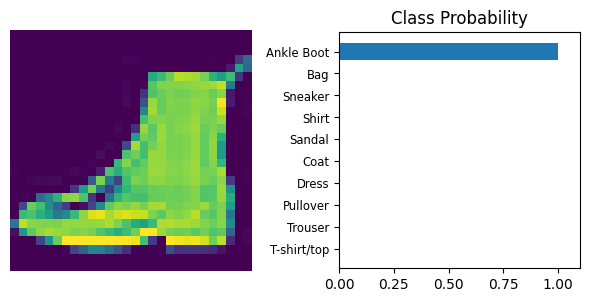

In [15]:
# print one image for each class and plot the class probability as classification
for images, labels in testloader:
    # Select the first image from the batch
    img = images[0]

    # Convert 2D image to 1D vector
    img = img.view(1, -1)

    with torch.no_grad():
        logps = model(img)

    # Output of the network are log-probabilities, need to take exponential for probabilities
    ps = torch.exp(logps)

    # Plot the image and probabilities
    view_classify(img.view(1, 28, 28), ps)

    break  # Break after the first image